In [1]:
from datasets import get_dataloaders

from easydict import EasyDict as edict
from train_lightning import train
import wandb
import os

os.environ["TORCH_HOME"] = "~/storage/cache"
args = edict()
args.losses = "class"
args.train_method = "rep_train"
args.dataset = "3dshapes_random"
args.sub_dataset = int(args.dataset.split("_")[1]) if "idsprites" in args.dataset else args.dataset.split("_")[1]
args.dataset = args.dataset.split("_")[0]
args.data_dir = "idsprites" if args.dataset == "idsprites" else "3dshapes"  
args.num_epochs = 100
args.pretrained_feats = False
args.pretrained_id = None #"yxmihnpi" #"am7g7cqg"
args.pretrained_epoch = 50
args.pretrain_method = None #"rep_train" # Method which trained the pretrained model
args.pretrained_reps = None #"vit_b_16" #"vit_b_16" # "vit_b_16" #"vit_b_16" # only use with train_method == "rep_train"
args.resume = False
args.resume_id = None
args.experiment_id = None
args.train_bs = 32
args.encoder = {
    'pretrained': False,
    "enc_dims": 32,
   # 'output_dim': 384, # vit_b_16: 784, vit_b_32: 784 # vit: 384.
    'id': args.pretrained_id,
    'epoch': args.pretrained_epoch,
    "pretrain_method": args.pretrain_method,
    "pretrain_reps": "vit_b_16", # reps used for pretraining
    'arch': "cnn",
    'frozen': False}
args.modulator = {'arch': "mlp", "hidden_dim": 32}
args.pretrained_arch = args.encoder['arch'] if args.encoder['pretrained'] and args.encoder['frozen'] else None


args.seed = 444
args.test = False
args.save_weights = not args.test
args.save_metrics = not args.test
args.save_every = 10
args.num_workers = 0
METRICS_PER_METHOD = {
                      "erm": ['acc'],
                      "task_jepa": ['acc'], 
                      "ijepa": ['acc'],
                      "task_jepa+erm": ['acc'],
                      "pair_erm": ["acc"],
                      "encoder_erm": ['acc'],
                        "rep_train": ["acc"]
                     }

FOVS = {"3dshapes": {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15},
        "idsprites": {'shape': 10, 'scale': 10, 'orientation': 10, 
                          'x': 8, 'y': 4}
       }
FOVS_PER_DATASET = {'3dshapes': ["floor_hue", "wall_hue", "object_hue", "scale", "shape", "orientation"],
                   'idsprites': ["shape","scale","orientation","x","y"]
                   }
#FOVS_PER_DATASET = {'shapes3d': ["floor_hue", "wall_hue", "scale", "shape", "orientation"]}

args.best_model_criterion = "val_avg_acc"
args.metrics = METRICS_PER_METHOD[args.train_method]
args.fovs =  FOVS_PER_DATASET[args.dataset]
# Defines which tasks to optimize for when training under EncoderERM
args.fovs_tasks = args.fovs # ["floor_hue", "wall_hue", "object_hue", "scale", "shape", "orientation"]
args.fovs_indices = {name: i for i, name in enumerate(args.fovs)}
# When 2, 0 == same, 1 = different, When 3 levels, 0 = same, 1 = greater than, 2 = lower than
args.fovs_levels = {
                    '3dshapes': {"floor_hue": 2, "wall_hue": 2, "object_hue": 2, "scale": 3, "shape": 2, "orientation": 3},
                    'idsprites': {"shape": 3, "scale": 3, "orientation": 3, "x": 3, "y": 3}
                   }
args.fovs_ids = [args.fovs_indices[x] for x in args.fovs_tasks ]
args.n_fovs = FOVS[args.dataset]
args.task_to_label_index = {k: i for i, k in enumerate(args.fovs_tasks)}


# optimization
args.ema_start = 0.999 # starting value for exponential moving average for jepa methods
args.iters_per_ema = 16.0 # after how many iterations to apply ema
args.ipe_scale = 1.0
args.lr = 0.001
args.start_lr = 0.0002
args.final_lr = 1.0e-06
args.wd = 0.04
args.final_wd = 0.4
args.warmup = 2.0/15.0*args.num_epochs
args.num_steps = 10000
args.num_workers = 4

/home/araymond/storage/pyenv/versions/3.10.14/envs/mini/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
There was a problem when trying to write in your cache folder (/storage/cache). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.


In [4]:
train(args)

Loading dataloaders...
Loading 3dshapes dataset...
Recentering representations!
Normalizing reps!
Recentering representations!
Normalizing reps!


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alainray (alainray_puc). Use `wandb login --relogin` to force relogin


Creating model!
input_dim 256 hidden_dim 32
MLP(
  (proj): Linear(in_features=6, out_features=256, bias=True)
  (model): Sequential(
    (0): Linear(in_features=512, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | BigEncoder | 381 K 
1 | modulator | MLP        | 20.3 K
-----------------------------------------
401 K     Trainable params
0         Non-trainable params
401 K     Total params
1.606     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn

class BigEncoder(nn.Module):
    def __init__(self, args, d_hidden=256, hidden_dims=[32, 64, 128, 128, 64], avg_pool_pre_fc=False, **kwargs):
        super().__init__()

        encoder_d_hidden = d_hidden

        self.avg_pool_pre_fc = avg_pool_pre_fc
        #d = config.cae_reduce_factor

        modules = []
        if hidden_dims is None:
            # hidden_dims = [16, 32, 64, 64, 64]
            hidden_dims = [32, 64, 128, 256, 512]

        in_channels = 1 if args.dataset == "idsprites" else 3
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                    nn.Dropout(0.1),
                    # nn.MaxPool2d(3),
                    )
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc = nn.Linear(hidden_dims[-1]*4, encoder_d_hidden)

    def forward(self, x):
        x = self.encoder(x)
        if self.avg_pool_pre_fc:
            x = F.adaptive_avg_pool2d(x, (1,1)).squeeze()
        else:
            x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

    def get_features(self, x):
        # output = self.encoder(x).squeeze(-1).squeeze(-1)
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)

        x = self.fc(x)
        return x

data = torch.randn(10,3,64,64)
model = BigEncoder(args)
model(data).shape

In [2]:
dls = get_dataloaders(args)

Loading 3dshapes dataset...
Recentering representations!
Normalizing reps!
Recentering representations!
Normalizing reps!


In [3]:
len(dls['train'].dataset)

299289

In [26]:
a, b, c , d , e= next(iter(dls['train']))

In [27]:
a.shape, b.shape, c.shape, d.shape, e.shape

(torch.Size([11, 1, 64, 64]),
 torch.Size([11, 768]),
 torch.Size([11, 10, 1, 64, 64]),
 torch.Size([11, 10, 768]),
 torch.Size([11, 10, 5]))

In [3]:
from model_types import DownsizeTransformer

model = DownsizeTransformer()

In [4]:
batch = next(iter(dls['train']))

In [5]:
import torch
imgs, _, latents = batch
z_ls = torch.zeros_like(latents)

In [7]:
reps, encs1 = model(imgs[0], latents)
reps, encs2 = model(imgs[0], z_ls)

torch.Size([256, 49, 16]) torch.Size([256, 1, 16])
torch.Size([256, 49, 16]) torch.Size([256, 1, 16])


In [11]:
from sklearn.model_selection import train_test_split
def index_to_latent_id(idx):
    shape = (idx // (14**4)) % 54
    scale =  (idx // (14**3)) % 14
    orientation =  (idx // (14**2)) % 14
    x =  (idx // 14) % 14
    y =  idx % 14
    return (shape,scale,orientation,x,y)
    
def latent_id_to_split(latent, ood):
    latent = {k: v for k, v in zip(['shape','scale','orientation','x','y'], latent)}
    for k, v in ood.items():
        if latent[k] in v:
            return "ood"
    else:
        return "iid"
        

if args.dataset == "idsprites":
    ood = { # defines which attribute ids are out of distribution from training
        'shape': [1,18,35,52],
        'scale': [3,6,9,12],
        'orientation': [3,6,9,12],
        'x': [3,6,9,12],
        'y': [3,6,9,12]
    }
    # TODO: create train, val and test splits by creating the correct indices
    sample_size = 54 - args.n_shapes

    if args.n_shapes == 14:
        ood['shape'] = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13,
        15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33,
        34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52]
    elif args.n_shapes == 24:
        ood['shape'] = [1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 16,
          17, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38,
           41, 42, 44, 46, 48, 50, 51, 52]
    elif args.n_shapes == 34:
        ood['shape'] = [1, 6, 10, 12, 13, 15, 17, 18, 19, 22,
         24, 25, 26, 29, 30, 33, 34, 35, 39, 41, 46, 47, 49, 52]
    elif args.n_shapes == 54:
        ood['shape'] = [4, 20, 24, 34]
        
    all_indices = []
    dataset_size = 54*14*14*14*14
    for idx in range(dataset_size):
        latent_id = index_to_latent_id(idx)
        split = latent_id_to_split(latent_id,ood)

        if split == "iid":
            all_indices.append(idx)
    train_indices, _ = train_test_split(all_indices, test_size = 0.2, random_state=42)

In [12]:
len(train_indices)

400000

## Visualize some samples

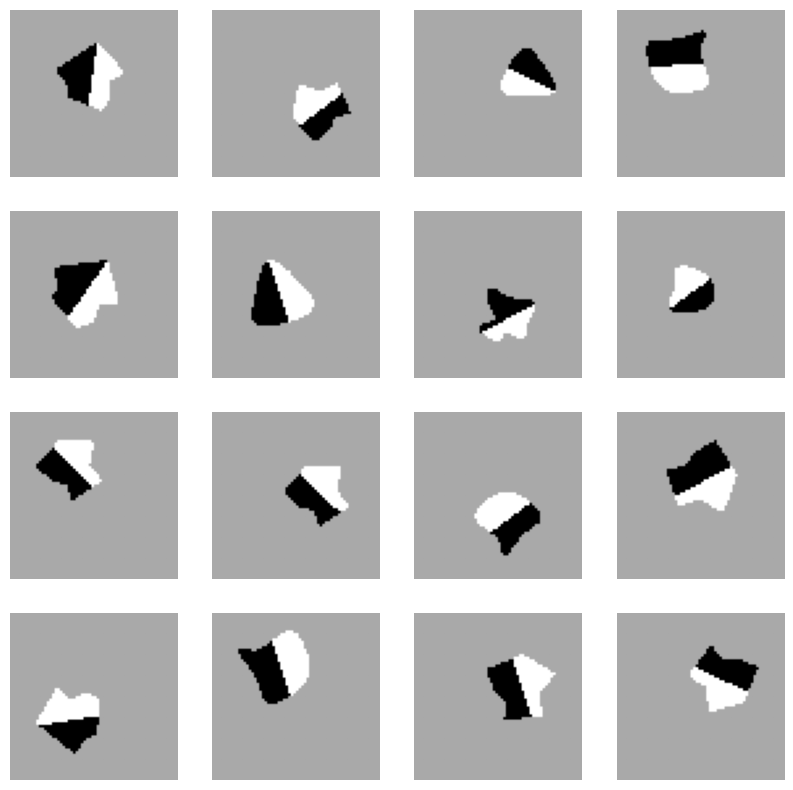

In [10]:
from torch.utils.data import DataLoader
from idsprites.visualization import draw_batch
dataloader = DataLoader(dls['train'].dataset, batch_size=16)
from pathlib import Path

path = Path("batch.png")
batch_img, factors = next(iter(dataloader))
img = draw_batch(batch_img, path , save=True, show=True)